# Mini projet n*1 - Chats ou Chiens ?

Dans ce projet, nosu allons étudier, classifier et segmenter les images du jeu de données Oxford-IIIT Pet Dataset. ce jeu de données comporte des images de chats et chiens de 35 races différentes.


In [1]:
# Utils
import os
#import shutil
import time
import tensorflow as tf


2025-11-26 11:26:07.049763: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-26 11:26:07.062814: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764152767.078587   31751 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764152767.083731   31751 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764152767.095095   31751 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Maths - Stats
import numpy as np
import pandas as pd
import random as rd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Data visualization
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image 

In [4]:
# Deep Learning Librairies
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import DenseNet121

## Chargement des données

In [5]:
list = "./annotations//list.txt"
image_dir = "./images"

# Chargement des images du dataset
images = [f for f in os.listdir(image_dir) if f.lower().endswith("jpg")]
print("Il y a ", len(images), "images dans le dataset.")

# Chargement des informations (label) des images, avec le fichier list.txt
df = pd.read_csv(
    list,
    sep=r'\s+',          
    comment='#',         
    header=None,         
    usecols=[0, 1, 2], 
    names=['image', # nom de l'image (sans extension)
           'class_id', # identifiant de la classe (race), entre 1 et 37
           'type'] # type d'animal : 1=chat, 2=chien
)
df["image"] = df["image"].apply(lambda x: x + ".jpg")
n_total = len(df)
print(f"Il y a {n_total} images référencées dans list.txt.")

# Vérification du référencement des images
missing_list = sorted(set(images) - set(df["image"])) # images dans le dataset sans entrée dans list.txt
missing_images = sorted(set(df["image"]) - set(images)) # images référencées dans list.txt mais manquantes dans le dataset
print(f"Il y a {len(missing_list)} images dans le dataset sans entrée dans list.txt.")
print(f"Il y a {len(missing_images)} images référencées dans list.txt mais manquantes dans le dataset.")  

pd.set_option('display.max_rows', None)    # affiche toutes les lignes
pd.set_option('display.max_columns', None) # affiche toutes les colonnes
pd.set_option('display.width', None)       # pas de coupure de lignes
pd.set_option('display.max_colwidth', None) # montre le texte entier dans chaque cellule

Il y a  7390 images dans le dataset.
Il y a 7349 images référencées dans list.txt.
Il y a 41 images dans le dataset sans entrée dans list.txt.
Il y a 0 images référencées dans list.txt mais manquantes dans le dataset.


Certaines images existent dans le dossier "images", mais n'ont pas d'entrées dans list.txt. On va donc les faire rentrer dans le jeu de données, en mettant comme identifiant de classe et type la même chose que les autres fichiers commençant par le même nom.

In [6]:
def get_prefix(filename):
    return filename.split('_')[0]

# Ajout d'informations dans le DataFrame
df["class"] = df["image"].apply(get_prefix)
df["animal"] = df["type"].apply(lambda x: "cat" if x == 1 else "dog")

# Création d'un dictionnaire de classes connues
classes = (
    df.groupby("class")[["class_id", "type"]]
      .first()
      .to_dict(orient="index")
)

# Ajout du référencement des images dans le DataFrame
new_rows = []
for img in missing_list :
    class_name = get_prefix(img)
    if class_name in classes: # Si on ne connait pas, on ne rajoute pas au DataFrame
        class_id = classes[class_name]["class_id"]
        type = classes[class_name]["type"]
        new_rows.append({
            "image": os.path.splitext(img)[0],
            "class_id": class_id,
            "type": type,
            "class": class_name,
            "animal": "cat" if type == 1 else "dog"
        })

print(f"{len(new_rows)} nouvelles lignes créées.")
df_new = pd.DataFrame(new_rows)
df_full = pd.concat([df, df_new], ignore_index=True)
df_full["image"] = df_full["image"].apply(
    lambda x: x + ".jpg" if not x.lower().endswith(".jpg") else x
)

missing_images = sorted(set(images) - set(df_full["image"]))
print(f"Il y a maintenant {len(missing_images)} images du dataset qui ne sont pas référencées dans le DataFrame.")


df_full.head()

41 nouvelles lignes créées.
Il y a maintenant 0 images du dataset qui ne sont pas référencées dans le DataFrame.


image  class_id  type       class animal
0  Abyssinian_100.jpg         1     1  Abyssinian    cat
1  Abyssinian_101.jpg         1     1  Abyssinian    cat
2  Abyssinian_102.jpg         1     1  Abyssinian    cat
3  Abyssinian_103.jpg         1     1  Abyssinian    cat
4  Abyssinian_104.jpg         1     1  Abyssinian    cat

In [7]:
# Nettoyage 
del(df)
df = df_full
del(new_rows)
del(df_new)
del(df_full)

## Analyse exploratoire

### Etude de la répartition par race et par type

In [8]:
df["class"] = df["class"].astype("str")
df["animal"] = df["animal"].astype("str")
df.dtypes

image       object
class_id     int64
type         int64
class       object
animal      object
dtype: object

In [9]:
nb_images = len(df)
n_class = df["class"].nunique()
n_class_cat = df[df["animal"] == "cat"]["class"].nunique()
n_class_dog = df[df["animal"] == "dog"]["class"].nunique()
nb_cat = len(df[df["animal"] == "cat"])
nb_dog = len(df[df["animal"] == "dog"])

print(f"Il y a {n_class} races différentes dans le dataset, pour {nb_images} images.")
print(f"Il y a {n_class_cat} races de chats et {n_class_dog} races de chiens.")
print(f"Cela représente {nb_cat} images de chats et {nb_dog} images de chiens.")


Il y a 35 races différentes dans le dataset, pour 7390 images.
Il y a 12 races de chats et 23 races de chiens.
Cela représente 2400 images de chats et 4990 images de chiens.


/tmp/ipykernel_6947/158086272.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts_2.values, y=counts_2.index, palette="pastel", ax=axes[0,1])


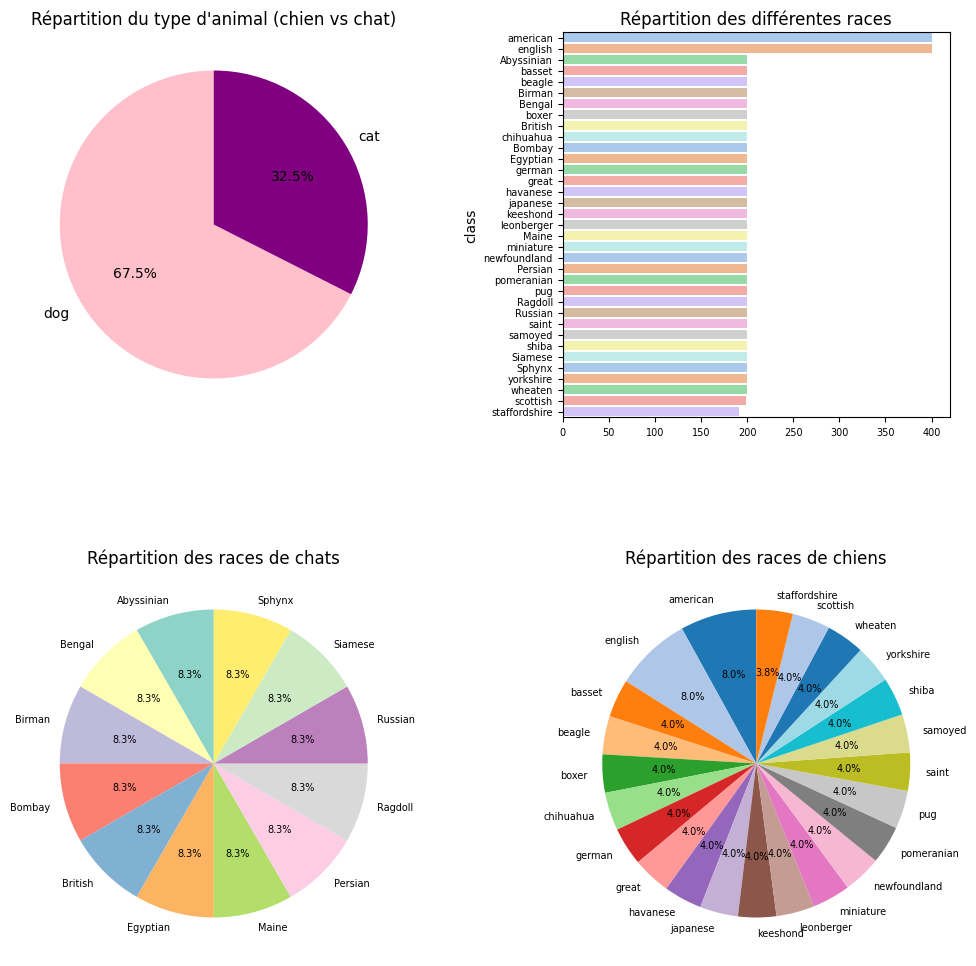

In [10]:
# Nombre d’images par type d'animal : chien vs chat
counts_1 = df["animal"].value_counts()

# Nombre d’images par race
counts_2 = df["class"].value_counts()

# Parmi les chats, répartition des races
counts_3 = df[df["animal"] == "cat"]["class"].value_counts()
counts_3 = counts_3[counts_3 > 0]
labels_cats =  [c for c in counts_3.index if counts_3[c] > 0]
palette_cat = sns.color_palette("Set3", n_colors=len(counts_3))

# Parmi les chiens, répartition des races
counts_4 = df[df["animal"] == "dog"]["class"].value_counts()
counts_4 = counts_4[counts_4 > 0]
labels_dogs =  [c for c in counts_4.index if counts_4[c] > 0]
palette_dog = sns.color_palette("tab20", n_colors=len(counts_4))

# Affichage des graphiques
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

axes[0,0].pie(counts_1, labels=counts_1.index, autopct='%1.1f%%', startangle=90, colors=["pink", "purple"])
axes[0,0].set_title("Répartition du type d'animal (chien vs chat)")

sns.barplot(x=counts_2.values, y=counts_2.index, palette="pastel", ax=axes[0,1])
axes[0,1].set_title("Répartition des différentes races")
axes[0,1].tick_params(axis='x', labelsize=7)
axes[0,1].tick_params(axis='y', labelsize=7) 

axes[1,0].pie(counts_3, labels=labels_cats, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 7}, colors=palette_cat)
axes[1,0].set_title("Répartition des races de chats")

axes[1,1].pie(x=counts_4,  labels=counts_4.index, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 7}, colors=palette_dog)
axes[1,1].set_title("Répartition des races de chiens")

plt.tight_layout
fig.subplots_adjust(hspace=0.4, wspace=0.4)  

plt.show()


Dans ce dataset, il y a beaucoup plus de chiens (67.5%) que de chats (32.5%). Malgré tout, les différentes races sont dans l'ensemble bien réparties puisqu'il y a 200 images pour chaque race, à l'exception des races "american" et "english", qui comportent 400 individus chacune. La race "staffordshire" comporte quant à elle un tout petit peu moins de 200 individus. Lorsque l'on regarde la répartion des 12 races de chats parmis les chats, elles sont parfaitement équilibrées. Pour la répartition des 27 races de chien, on avait effectivement remarqué que 2 étaient plus représentées que les autres. Le reste est néanmoins équilibré. 

### Vérification de la cohérence et la qualité des masques de segmentation

Un masque de segmentation est un masque de la même taille que l'image, qui va nous permettre d'avoir l'information du sujet de l'image. En effet, le masque va donner à chaque pixel de l'image une valeur parmi ces trois : 
- 1 si le pixel appartient au premier plan de l'image, soit l'animal dans notre cas 
- 2 si le pixel appartient à l'arrière-plan de l'image 
- 3 si le pixel n'est pas classifié.

Les masques de segmentation se trouvent dans le dossier *annotations/trimaps*. Nous allons donc regarder sur un petit jeu de données, sélectionné aléatoirement parmi notre dataset ce que donne le masque de segmentation. 


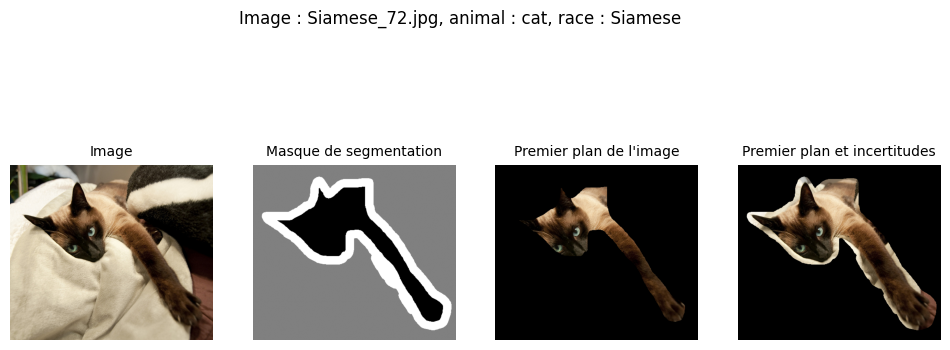

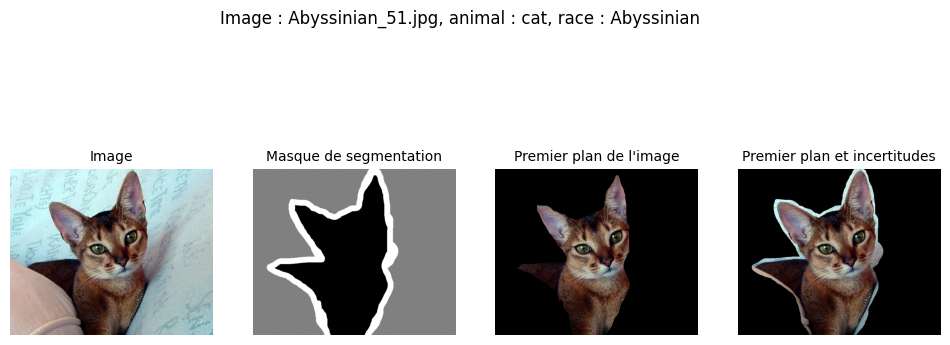

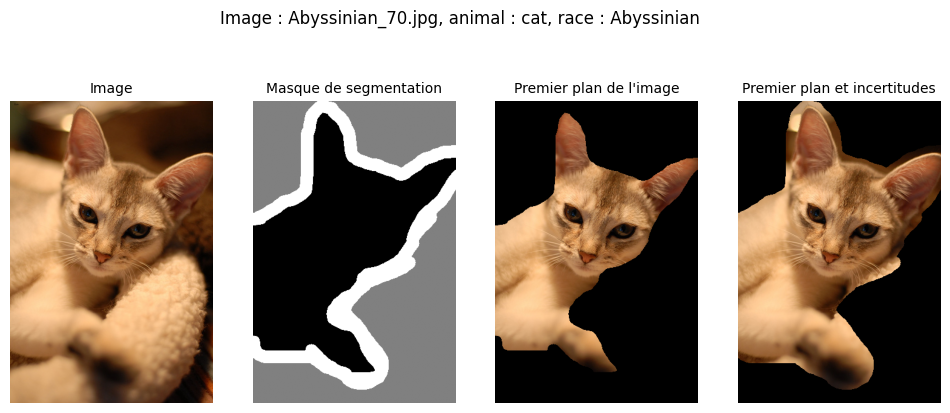

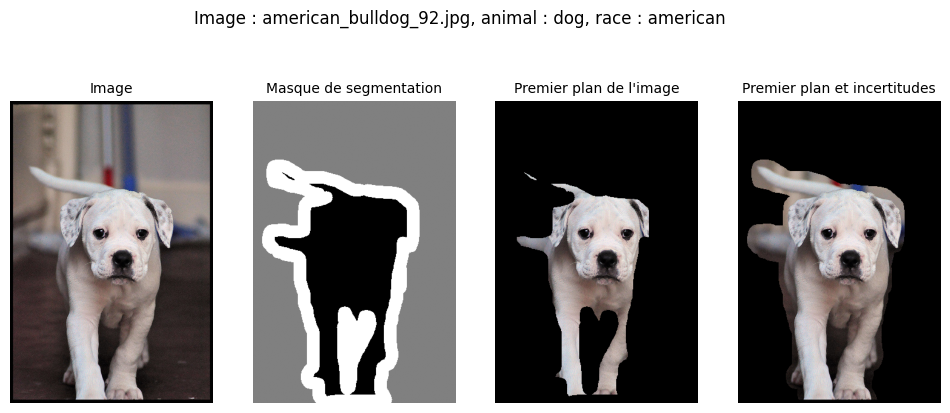

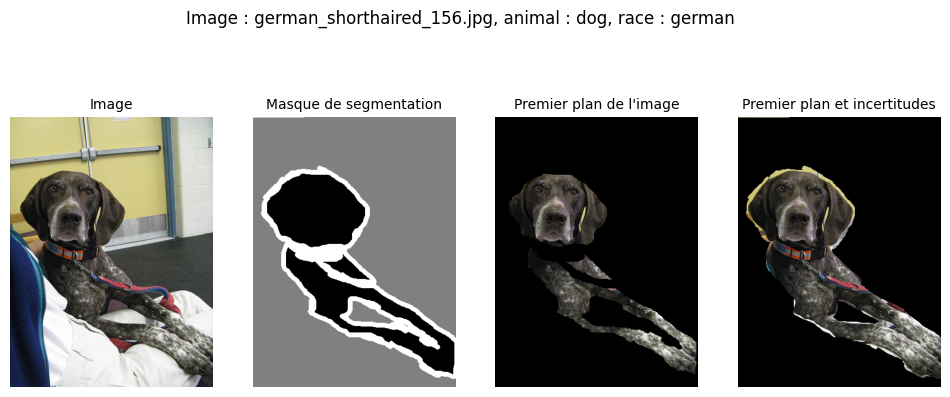

In [8]:
path_images = "./images/"
path_masks = "./annotations/trimaps/"

n = 5

for i in range(5): 
    # Sélection aléatoire d'une image
    filename = rd.choice(df['image'])

    # Chargement de l'image et du masque
    img = np.array(Image.open(path_images + filename))
    mask = np.array(Image.open(path_masks + filename.replace('.jpg', '.png')))

    # Image avec le masque appliqué (seulement le corps de l'animal)
    img_foreground = img.copy()
    img_foreground[mask != 1] = 0  

    # Image avec le masque appliqué (corps de l'animal + zone d'incertitude)
    img_background = img.copy()
    img_background[mask == 2] = 0

    fig, axes = plt.subplots(1, 4, figsize=(12, 5))
    fig.suptitle(f"Image : {filename}, animal : {df[df['image'] == filename]['animal'].values[0]}, race : {df[df['image'] == filename]['class'].values[0]}")

    axes[0].imshow(img)
    axes[0].set_title("Image", fontsize=10)
    axes[0].axis("off")

    axes[1].imshow(mask, cmap="gray")
    axes[1].set_title("Masque de segmentation", fontsize=10)
    axes[1].axis("off")

    axes[2].imshow(img_foreground)  
    axes[2].set_title("Premier plan de l'image", fontsize=10)
    axes[2].axis("off")

    axes[3].imshow(img_background)
    axes[3].set_title("Premier plan et incertitudes", fontsize=10)
    axes[3].axis("off")

    plt.show()

Cela nous permet de vérifier que les masques sont cohérents avec l'image. Cependant, pour certaines photos, la zone d'incertitude peut être assez grande. C'est notamment le cas lorsque l'animal est de la même couleur que l'arrière plan, qu'il est caché par un objet, qu'il a des moustaches ou un collier. 

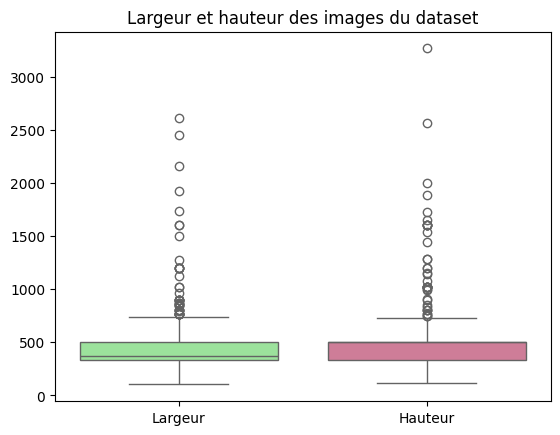

In [12]:
img_size = np.zeros((df.shape[0],2))
for i, filename in enumerate(df['image']) :
    img = img_to_array(load_img(path_images + filename) )
    img_size[i,:] = img.shape[:2]

plt.figure()
ax = sns.boxplot(img_size, palette = ['lightgreen', 'palevioletred'])
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(['Largeur', 'Hauteur'])
plt.title("Largeur et hauteur des images du dataset")
plt.show()

On peut voir que les hauteurs et largeurs des images sont bien différentes. Pour la suite, on va les faire passer dans des réseaux de convolution. Il est donc intéressant d'avoir des images de même taille. 

## Classification binaire

Le premier objectif est de faire une classification binaire : à partir d'une photo, le but est de déterminer si elle montre un chat ou un chien.

### Pré - traitement des données

Dans un premier temps, nous séparons le jeu de données en un jeu de données pour l'entrainement, un pour la validation et un dernier qui sera utilisé pour tester le modèle à la fin.

In [9]:
N_train = 5200 # taille du jeu d'entrainement
N_validation = 1400 # taille du jeu de validation

print("Pourcentage des données utilisées pour l'entrainement : ", N_train/len(df))
print("Pourcentage des données utilisées pour la validation : ", N_validation/len(df))
print("Pourcentage des données utilisées pour le test : ", (len(df) - N_train - N_validation)/len(df))

# Séparation des données en un jeu de données d'entrainement (80%) et un jeu de données de test (20%)
test_df, train_df = train_test_split(df, test_size=N_train)
test_df, validation_df = train_test_split(test_df, test_size=N_validation)

Pourcentage des données utilisées pour l'entrainement :  0.7036535859269283
Pourcentage des données utilisées pour la validation :  0.18944519621109607
Pourcentage des données utilisées pour le test :  0.10690121786197564


In [10]:
# Vérification de la répartition des chiens et des chats dans les deux jeux de données
ratio_test = test_df['animal'].value_counts(normalize=True) * 100
ratio_train = train_df['animal'].value_counts(normalize=True) * 100
ratio_validation = validation_df['animal'].value_counts(normalize=True) * 100

print("Part de chien et chat dans les données d'entrainement")
print(ratio_train)
print("Part de chien et chat dans les données de test")
print(ratio_test)
print("Part de chien et chat dans les données de validation")
print(ratio_validation)

Part de chien et chat dans les données d'entrainement
animal
dog    67.538462
cat    32.461538
Name: proportion, dtype: float64
Part de chien et chat dans les données de test
animal
dog    66.455696
cat    33.544304
Name: proportion, dtype: float64
Part de chien et chat dans les données de validation
animal
dog    68.071429
cat    31.928571
Name: proportion, dtype: float64


Les trois jeux de données (entraînement, test et validation) sont plutôt bien équilibrés : il y a quasiment la même proportion de chats et de chiens dans les trois. Ces proportions se rapprochent également des 67.5% de chiens et 32.5% de chats présents dans le dataframe initial. 

Passons maintenant au redimensionnement des images. Il faut être vigilant à ce que la variable $\textit{batch\_size}$ soit un diviseur de $N_{\text{train}}$ et $N_{\text{test}}$, qui sont respectivement les tailles du jeu d'entraînement et de validation.

Remarque : il est primordial ici d'ajouter "shuffle=False" dans le test_generator car sinon pour la visualisation, on va prédire sur le générateur (donc un ordre désordonné du df) et les images plots vont (comparaison) sont sur le df de base donc forcement ca sera faux.

In [11]:
img_width = 150
img_height = 150
batch_size = 20 # Diviseur de N_train et N_validation

# Images d'entrainement
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    path_images,
    x_col = 'image',
    y_col = 'animal',
    target_size = (img_width, img_height),
    class_mode = 'binary',
    batch_size = batch_size
)

# Images de validation
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    path_images,
    x_col = 'image',
    y_col = 'animal',
    target_size = (img_width, img_height),
    class_mode = 'binary',
    batch_size = batch_size
)

# Images de test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    path_images,
    x_col = 'image',
    y_col = 'animal',
    target_size = (img_width, img_height),
    class_mode = 'binary',
    batch_size = batch_size,
    shuffle=False   #pour garder les bons indices: les images sont chargées dans l’ordre exact du dataframe
)

Found 5200 validated image filenames belonging to 2 classes.
Found 1400 validated image filenames belonging to 2 classes.
Found 790 validated image filenames belonging to 2 classes.


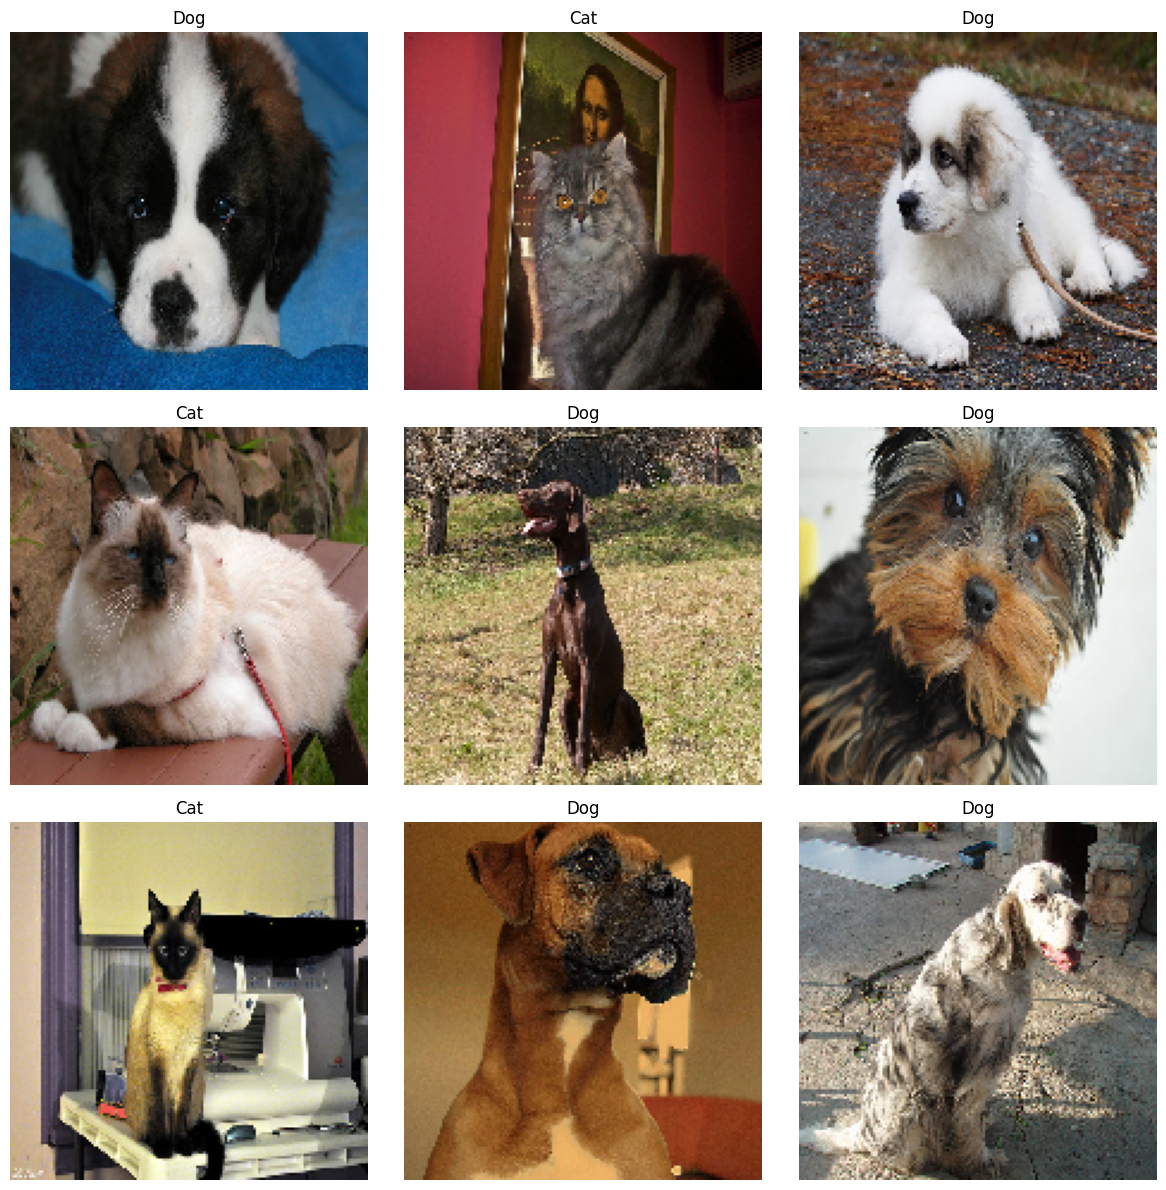

In [12]:
labels = {0: 'Cat', 1: 'Dog'}

# Visualisation de quelques images d'entrainement, redimensionnées
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    for x_batch, y_batch in train_generator:
        img = x_batch[0]
        plt.title(labels.get(y_batch[0]))
        plt.imshow(img)
        plt.axis('off')
        plt.grid(False)
        break
plt.tight_layout()
plt.show()

### Première approche : réseau de convolution simple

Une première approche pour notre problème est d'utiliser un réseau convolutif. Nous allons construire une version simplifiée de AlexNet. 


Les trois premiers blocs de ce réseau sont de la forme :
- Une couche de convolution, avec des filtres de taille $3 \times 3$ filtres et qui utilise la fonction d'activation $\texttt{Relu}$. Le premier a 32 filtres, le deuxième 64 et le dernier 96
- Une couche de MaxPooling, avec une fenêtre de $2 \times 2$

A la suite de ces trois blocs, on trouve :
- Une couche flatten, afin que les canaux puissent être lus par le réseau de neuronne 
- Une couche dense avec 64 neuronnes, qui utilise la fonction d'activation $\texttt{Relu}$ 
- Une couche dropout, qui met à 0 50% des sorties de la couche précédente. Cela permet une certaine régularisation
- Une couche dense avec un neuronne et une couche d'activation $\texttt{Sigmoid}$ 

In [17]:
# Création du modèle 
 
cnn_simple = Sequential()
cnn_simple.add(Input(shape=(img_width,img_height,3)))

cnn_simple.add(Conv2D(32, (3,3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2,2)))

cnn_simple.add(Conv2D(64, (3,3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2,2)))

cnn_simple.add(Conv2D(96, (3,3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2,2)))

cnn_simple.add(Flatten())

cnn_simple.add(Dense(64, activation='relu'))
cnn_simple.add(Dropout(0.5))
cnn_simple.add(Dense(1, activation='sigmoid'))

In [18]:
# Entraînement du modèle
cnn_simple.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy'])

epochs = 10

t_learning_cnn_simple = time.time()
cnn_simple_history = cnn_simple.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_cnn_simple = time.time() - t_learning_cnn_simple

print("Temps d'apprentissage pour %d epochs : %d secondes" % (epochs, t_learning_cnn_simple))

Epoch 1/10


260/260 [==============================] - 170s 623ms/step - loss: 0.6025 - accuracy: 0.6777 - val_loss: 0.5664 - val_accuracy: 0.7086
Epoch 2/10
260/260 [==============================] - 166s 638ms/step - loss: 0.5511 - accuracy: 0.7060 - val_loss: 0.5856 - val_accuracy: 0.6836
Epoch 3/10
260/260 [==============================] - 182s 700ms/step - loss: 0.5168 - accuracy: 0.7269 - val_loss: 0.5328 - val_accuracy: 0.7336
Epoch 4/10
260/260 [==============================] - 197s 755ms/step - loss: 0.4812 - accuracy: 0.7652 - val_loss: 0.5348 - val_accuracy: 0.7357
Epoch 5/10
260/260 [==============================] - 211s 811ms/step - loss: 0.4465 - accuracy: 0.7860 - val_loss: 0.4818 - val_accuracy: 0.7786
Epoch 6/10
260/260 [==============================] - 206s 793ms/step - loss: 0.4158 - accuracy: 0.8075 - val_loss: 0.5149 - val_accuracy: 0.7700
Epoch 7/10
260/260 [==============================] - 125s 478ms/step - loss: 0.3869 - accuracy: 0.8262 - val_loss: 0.4610

In [13]:
# Fonctions utiles pour analyser les résultats

def prediction(model, train_generator, validation_generator):
    t_prediction = time.time()
    score_train = model.evaluate(train_generator, verbose=1)
    score_validation = model.evaluate(validation_generator, verbose=1)
    t_prediction = time.time() - t_prediction

    print('Train accuracy:', score_train[1])
    print('Validation accuracy:', score_validation[1])
    print("Time Prediction: %.2f seconds" % t_prediction)
    

def plot_training_analysis(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, color='cadetblue', linestyle="--",label='Training accuracy')
    plt.plot(epochs, val_acc, color='sandybrown', label='Validation accuracy')
    plt.title('Training et validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, color='cadetblue', linestyle="--",label='Training loss')
    plt.plot(epochs, val_loss, color='sandybrown', label='Validation loss')
    plt.title('Training et validation loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

70/70 [==============================] - 8s 115ms/step - loss: 0.4701 - accuracy: 0.7864
Train accuracy: 0.9253846406936646
Validation accuracy: 0.7864285707473755
Time Prediction: 40.01 seconds


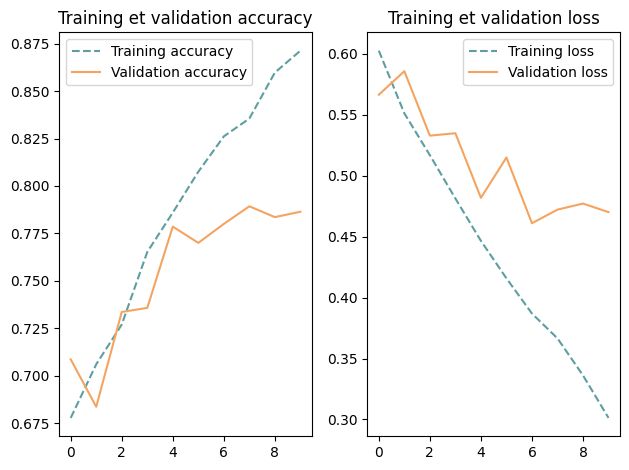

In [20]:
prediction(cnn_simple, train_generator, validation_generator)
plot_training_analysis(cnn_simple_history)

La précision obtenue est plutôt correcte : 82% pour les données de validation, et 95% pour les données d'entraînement. Cependant, on observe un surapprentissage clair : alors qu'à la moitié de l'apprentissage, les courbes de validation se stabilisent (cesse d'augmenter pour l'accuracy, de diminuer pour la loss), les courbes pour le training, elles, continuent d'évoluer. Une solution pour pallier ce problème est de faire de l'augmentation de data.

### CNN simple avec data augmentation

Afin d'éviter l'overfitting, une solution consiste à utilise l'augmentation de données. En effet, en transformant les images d'apprentissage (rotation, décalage...), on a un jeu de données bien plus grand, ce qui peut limiter le surapprentissage. On pourra ensuite suivre la même démarche que précédemment.

In [14]:
train_datagen_augmented = ImageDataGenerator(
    rotation_range = 40,
    rescale = 1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest'
)

train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
    train_df,
    path_images,
    x_col = 'image',
    y_col = 'animal',
    target_size=(img_width,img_height),
    class_mode = 'binary',
    batch_size = batch_size
)

Found 5200 validated image filenames belonging to 2 classes.


In [25]:
cnn_simple = Sequential()
cnn_simple.add(Input(shape=(img_width,img_height,3)))

cnn_simple.add(Conv2D(32, (3,3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2,2)))

cnn_simple.add(Conv2D(64, (3,3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2,2)))

cnn_simple.add(Conv2D(96, (3,3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2,2)))

cnn_simple.add(Flatten())

cnn_simple.add(Dense(64, activation='relu'))
cnn_simple.add(Dropout(0.5))
cnn_simple.add(Dense(1, activation='sigmoid'))

epochs = 10

cnn_simple.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy']
)

t_learning_cnn_simple_augmented = time.time()

cnn_simple_augmented_history = cnn_simple.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)

t_learning_cnn_simple_augmented = time.time() - t_learning_cnn_simple_augmented

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_cnn_simple_augmented))

/home/helleu/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 31s 111ms/step - accuracy: 0.6761 - loss: 0.6273 - val_accuracy: 0.6764 - val_loss: 0.6359
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 29s 111ms/step - accuracy: 0.6808 - loss: 0.5918 - val_accuracy: 0.6786 - val_loss: 0.5943
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - accuracy: 0.6891 - loss: 0.5783 - val_accuracy: 0.7179 - val_loss: 0.5497
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - accuracy: 0.7078 - loss: 0.5613 - val_accuracy: 0.7086 - val_loss: 0.5753
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 99ms/step - accuracy: 0.7279 - loss: 0.5439 - val_accuracy: 0.7050 - val_loss: 0.5544
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - accuracy: 0.7160 - loss: 0.5593 - val_accuracy: 0.7143 - val_loss: 0.5686
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - accuracy: 0.7301 - loss: 0.5306 - val_accuracy: 0.7543 - val_loss: 0.5102
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - accuracy: 0.7475 - loss: 0.

260/260 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.7817 - loss: 0.4441
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.7762 - loss: 0.4598
Train accuracy: 0.7796154022216797
Validation accuracy: 0.7685714364051819
Time Prediction: 16.69 seconds


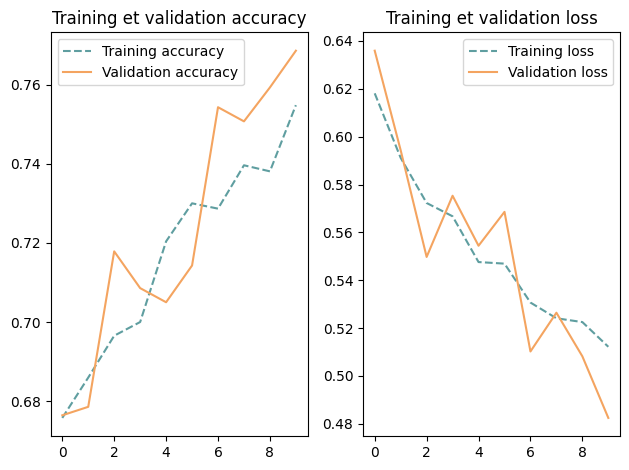

In [27]:
prediction(cnn_simple, train_generator, validation_generator)
plot_training_analysis(cnn_simple_augmented_history)

On remarque que l'overfitting a diminué. En effet, les courbes suivent désormais la même trajectoire. De plus, les précisions obtenues pour les données d'apprentissage et de validation sont du même ordre de grandeur. Même si ces résultats sont corrects (75 à 80% de précision), ils peuvent être améliorés. Une solution consiste à utiliser le Transfer Learning.

### Transfer Learning avec augmentation de données

Le Transfer Learning consiste à utiliser un réseau déjà entraîné pour notre problème. Cela permet de mieux détecter les formes de l'image, et ainsi de mieux distinguer les chats et les chiens. On utilise ici VGG16, qui est composé de 5 blocs de convolution puis d'un MLP classique. Nous allons garder les poids du réseau de convolution, et construire notre propre MLP ensuite.

In [15]:
conv_base = VGG16(
    weights = 'imagenet', # On garde les poids de l'entraînement sur le jeu de données ImageNet
    include_top = False,  # On ne garde pas la partie Dense
    input_shape = (img_width, img_height, 3)
)

conv_base.summary()

I0000 00:00:1764152830.183371   31751 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13828 MB memory:  -> device: 0, name: NVIDIA RTX 2000 Ada Generation, pci bus id: 0000:55:00.0, compute capability: 8.9


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Création du réseau en ajoutant un MLP après le réseau de convolution VGG16
vgg_combined = Sequential()
vgg_combined.add(Input(shape=(img_width, img_height, 3)))
vgg_combined.add(conv_base)
vgg_combined.add(Flatten())
vgg_combined.add(Dense(256, activation='relu'))
vgg_combined.add(Dense(1, activation='sigmoid'))

conv_base.trainable = False # On fige les poids de VGG

vgg_combined.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [32]:
# Apprentissage 

epochs = 5

vgg_combined.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy']
)

t_learning_vgg_combined = time.time()
vgg_combined_history = vgg_combined.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_vgg_combined = time.time() - t_learning_vgg_combined

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_combined))

Epoch 1/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 31s 103ms/step - accuracy: 0.7604 - loss: 0.4911 - val_accuracy: 0.8514 - val_loss: 0.3282
Epoch 2/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - accuracy: 0.8388 - loss: 0.3519 - val_accuracy: 0.8957 - val_loss: 0.2412
Epoch 3/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - accuracy: 0.8454 - loss: 0.3366 - val_accuracy: 0.8879 - val_loss: 0.2424
Epoch 4/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - accuracy: 0.8638 - loss: 0.3217 - val_accuracy: 0.9014 - val_loss: 0.2232
Epoch 5/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - accuracy: 0.8623 - loss: 0.3112 - val_accuracy: 0.8964 - val_loss: 0.2283
Learning time for 5 epochs : 136 seconds


260/260 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9144 - loss: 0.2063
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9014 - loss: 0.2261
Train accuracy: 0.9119230508804321
Validation accuracy: 0.8964285850524902
Time Prediction: 14.42 seconds


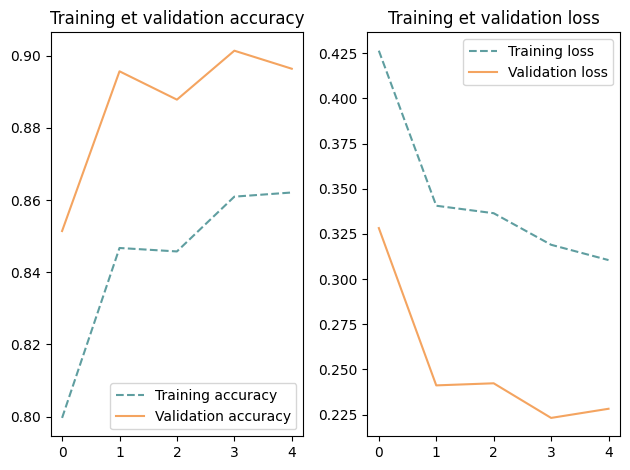

In [33]:
prediction(vgg_combined, train_generator, validation_generator)
plot_training_analysis(vgg_combined_history)

Les précisions obtenues sont bien meilleures que précédemment (environ 90%). On peut essayer de les améliorer en faisant un apprentissage sur les poids du réseau VGG.  

Nous allons libérer les poids du dernier bloc de convolution de VGG pour qu'il soit libre pour l'apprentissage. On espère ainsi que VGG s'adaptera à notre problème et qu'on aura des meilleurs résultats que précédemment. 

In [35]:
conv_base.trainable = True
for layer in conv_base.layers[:15]:
    layer.trainable = False # On fige les poids des 4 premiers blocs de convolution de VGG

In [ ]:
# Apprentissage 
 
epochs = 5

vgg_combined.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=1e-4), # Learning rate plus faible pour ne pas écraser ce qui a été appris précédemment
    metrics = ['accuracy']
)

t_learning_vgg_combined_tuned = time.time()
vgg_combined_tuned_history = vgg_combined.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_vgg_combined_tuned = time.time() - t_learning_vgg_combined_tuned

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_combined_tuned))

Epoch 1/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 33s 117ms/step - accuracy: 0.8400 - loss: 0.3785 - val_accuracy: 0.9379 - val_loss: 0.1662
Epoch 2/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - accuracy: 0.8976 - loss: 0.2337 - val_accuracy: 0.9271 - val_loss: 0.1877
Epoch 3/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - accuracy: 0.9191 - loss: 0.1962 - val_accuracy: 0.9464 - val_loss: 0.1373
Epoch 4/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - accuracy: 0.9362 - loss: 0.1569 - val_accuracy: 0.9536 - val_loss: 0.1468
Epoch 5/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - accuracy: 0.9465 - loss: 0.1378 - val_accuracy: 0.9500 - val_loss: 0.1261
Learning time for 5 epochs : 140 seconds


In [48]:
prediction(vgg_combined, train_generator, validation_generator) #pk c'est aps train generator augmented ?
plot_training_analysis(vgg_combined_tuned_history)

NameError: name 'vgg_combined' is not defined

Les résultats obtenus sont bien meilleurs que précédemment, jusqu'à atteindre 95% de précision. La fonction perte décroit elle aussi de manière significative par rapport à l'étape précédente. Essayons maintenant de faire un entraînement sur tous les poids du modèle. 

In [ ]:
conv_base.trainable = True # On libère tous les poids du modèle

In [39]:
# Apprentissage 
 
epochs = 5

vgg_combined.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=1e-5), # Learning rate plus faible pour ne pas écraser ce qui a été appris précédemment
    metrics = ['accuracy']
)

t_learning_vgg_combined_tuned2 = time.time()
vgg_combined_tuned_history2 = vgg_combined.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_vgg_combined_tuned2 = time.time() - t_learning_vgg_combined_tuned2

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_combined_tuned))

Epoch 1/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - accuracy: 0.9650 - loss: 0.0911 - val_accuracy: 0.9600 - val_loss: 0.1073
Epoch 2/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - accuracy: 0.9682 - loss: 0.0783 - val_accuracy: 0.9636 - val_loss: 0.1015
Epoch 3/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - accuracy: 0.9743 - loss: 0.0658 - val_accuracy: 0.9664 - val_loss: 0.1075
Epoch 4/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 105ms/step - accuracy: 0.9690 - loss: 0.0652 - val_accuracy: 0.9664 - val_loss: 0.1032
Epoch 5/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 105ms/step - accuracy: 0.9778 - loss: 0.0623 - val_accuracy: 0.9657 - val_loss: 0.0999
Learning time for 5 epochs : 140 seconds


260/260 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9937 - loss: 0.0171
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9716 - loss: 0.0860
Train accuracy: 0.9932692050933838
Validation accuracy: 0.9657142758369446
Time Prediction: 14.40 seconds


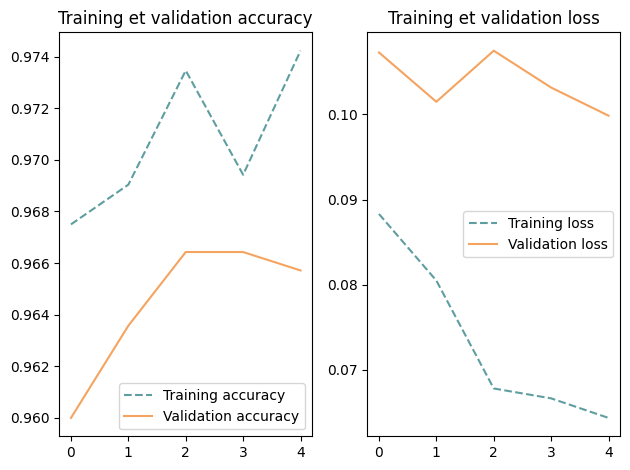

In [40]:
prediction(vgg_combined, train_generator, validation_generator)
plot_training_analysis(vgg_combined_tuned_history2)

La précision obtenue avec ce dernier modèle monte jusqu'à 98%, ce qui est bien mieux. De même, la fonction perte a encore diminué de manière significative. Les fonctions de précision et de perte n'évoluant plus beaucoup, il est maintenant temps de tester ce modèle final.

### Test du modèle final

In [41]:
test_prediction = vgg_combined.predict(test_generator)
score_test = vgg_combined.evaluate(test_generator)
print('Test accuracy:', score_test[1])

/home/helleu/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9622 - loss: 0.1434
Test accuracy: 0.9670885801315308


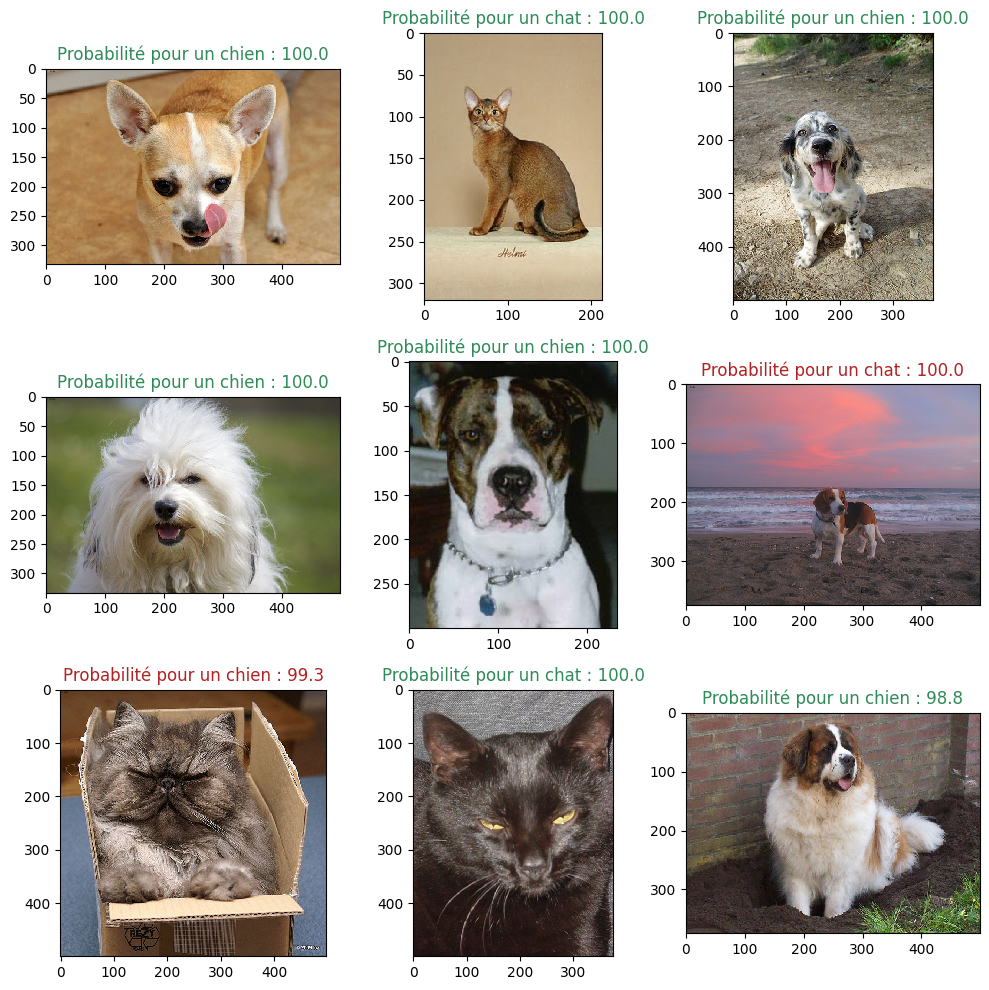

In [42]:
fig = plt.figure(figsize=(10,10))

test_imgs_idx = np.random.randint(low=0, high=test_df.shape[0], size=(9,))

for i, idx in enumerate(test_imgs_idx):
    filename = test_df['image'].iloc[idx]
    img = img_to_array(load_img(path_images + filename) ) / 255
    pred = test_prediction[idx][0]
    
    ax = fig.add_subplot(3,3,i+1)
    ax.imshow(img, interpolation='nearest')
    color = "seagreen"
    type = test_df['animal'].iloc[idx]
    
    if pred >0.5:
        title = "Probabilité pour un chien : %.1f" % (pred*100)
        if type == 'cat':
            color = "firebrick"
    else:
        title = "Probabilité pour un chat : %.1f" %((1-pred)*100)
        if type == 'dog':
            color = "firebrick"
    ax.set_title(title, color=color)

plt.tight_layout()
plt.show()

En testant ce modèle sur le jeu de données de test, on obtient une précision de 96%, ce qui est tout à fait correct. En observant les images, on peut observer les erreurs du modèle.

## Classification fine

### Transfer Learning avec Vgg16

L'objectif ici est de réussir à identifier les différentes races parmi les 35 disponibles (pourquoi dans le sujets ils disent 
35). Une difficulté se présentera: la confusion de plusieurs races proches.

Je commence par prendre le même modèle que précédemment: modèle de transfer learning à partir de VGG16.

In [16]:
conv_base = VGG16(
    weights = 'imagenet', # On garde les poids de l'entraînement sur le jeu de données ImageNet
    include_top = False,  # On ne garde pas la partie Dense
    input_shape = (img_width, img_height, 3)
)

conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Création du réseau en ajoutant un MLP après le réseau de convolution VGG16
vgg_combined_fine = Sequential()
vgg_combined_fine.add(Input(shape=(img_width, img_height, 3)))
vgg_combined_fine.add(conv_base)
vgg_combined_fine.add(Flatten())
vgg_combined_fine.add(Dense(256, activation='relu'))
vgg_combined_fine.add(Dense(35, activation='softmax')) #car 35 especes

conv_base.trainable = False # On fige les poids de VGG

vgg_combined_fine.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 35)             │         8,995 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,821,091 (64.17 MB)

 Trainable params: 2,106,403 (8.04 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [18]:
train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
    train_df,
    path_images,
    x_col = 'image',
    y_col = 'class',
    target_size=(img_width,img_height),
    class_mode = 'categorical',
    batch_size = batch_size
)

# Images de validation
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    path_images,
    x_col = 'image',
    y_col = 'class',
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    batch_size = batch_size
)

# Images de test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    path_images,
    x_col = 'image',
    y_col = 'class',
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle=False
)

Found 5200 validated image filenames belonging to 35 classes.
Found 1400 validated image filenames belonging to 35 classes.
Found 790 validated image filenames belonging to 35 classes.


In [19]:
# Apprentissage 

epochs = 5

vgg_combined_fine.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy']
)

t_learning_vgg_combined_fine = time.time()
vgg_combined_history = vgg_combined_fine.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_vgg_combined_fine = time.time() - t_learning_vgg_combined_fine

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_combined_fine))

/home/roumazei/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1764152870.007766   32518 service.cc:152] XLA service 0x7d34e401e940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764152870.007800   32518 service.cc:160]   StreamExecutor device (0): NVIDIA RTX 2000 Ada Generation, Compute Capability 8.9
2025-11-26 11:27:50.030488: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764152870.294933   32518 cuda_dnn.cc:529] Loaded cuDNN version 91600
2025-11-26 11:27:51.543279: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1035', 68 bytes spill stores, 68 bytes spill loads

2025-11-26 11:27:51.753440: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_do

  3/260 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.0306 - loss: 3.7288

I0000 00:00:1764152875.324297   32518 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


260/260 ━━━━━━━━━━━━━━━━━━━━ 33s 103ms/step - accuracy: 0.1033 - loss: 3.3532 - val_accuracy: 0.3586 - val_loss: 2.3123
Epoch 2/5
 82/260 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - accuracy: 0.3175 - loss: 2.4818

KeyboardInterrupt: 

In [56]:
prediction(vgg_combined_fine, train_generator_augmented, validation_generator)

260/260 ━━━━━━━━━━━━━━━━━━━━ 23s 88ms/step - accuracy: 0.4762 - loss: 1.7863
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.4938 - loss: 1.6887
Train accuracy: 0.47769230604171753
Validation accuracy: 0.49071428179740906
Time Prediction: 26.15 seconds


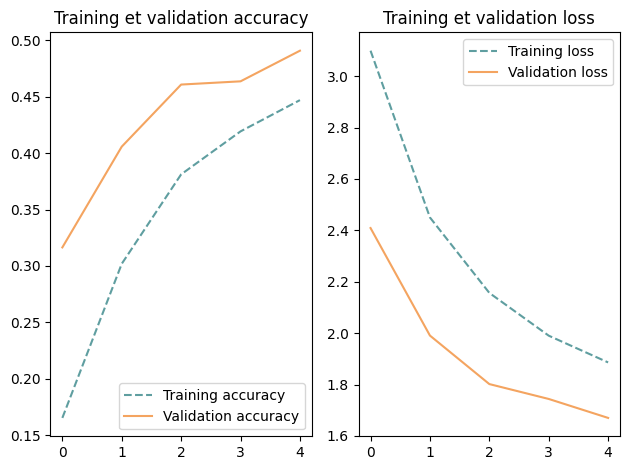

In [57]:
plot_training_analysis(vgg_combined_history)

Les résultats obtenus ne sont pas très bons en terme d'accuracy. Essayons en ne figeant plus les poids du modèle VGG16, c'est à dire que ceux-ci sont aussi modifiés et ajustés.

### Libération des poids de vggg16 : fine-tuning (les termes)

In [58]:
conv_base.trainable = True # On libère tous les poids du modèle

In [59]:
# Apprentissage 
 
epochs = 5

vgg_combined_fine.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate=1e-5), # Learning rate plus faible pour ne pas écraser ce qui a été appris précédemment
    metrics = ['accuracy']
)

t_learning_vgg_combined_tuned2 = time.time()
vgg_combined_tuned_history2 = vgg_combined_fine.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_vgg_combined_tuned2 = time.time() - t_learning_vgg_combined_tuned2

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_combined_tuned2))

Epoch 1/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 36s 124ms/step - accuracy: 0.5473 - loss: 1.5098 - val_accuracy: 0.6336 - val_loss: 1.1558
Epoch 2/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 32s 121ms/step - accuracy: 0.6337 - loss: 1.1673 - val_accuracy: 0.6693 - val_loss: 1.0805
Epoch 3/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 33s 125ms/step - accuracy: 0.7038 - loss: 0.9947 - val_accuracy: 0.6736 - val_loss: 1.0804
Epoch 4/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 33s 127ms/step - accuracy: 0.7069 - loss: 0.9163 - val_accuracy: 0.7400 - val_loss: 0.8643
Epoch 5/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 32s 124ms/step - accuracy: 0.7617 - loss: 0.7571 - val_accuracy: 0.7357 - val_loss: 0.8226
Learning time for 5 epochs : 165 seconds


260/260 ━━━━━━━━━━━━━━━━━━━━ 24s 93ms/step - accuracy: 0.7906 - loss: 0.6948
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.7570 - loss: 0.7739
Train accuracy: 0.7876923084259033
Validation accuracy: 0.7357142567634583
Time Prediction: 27.96 seconds


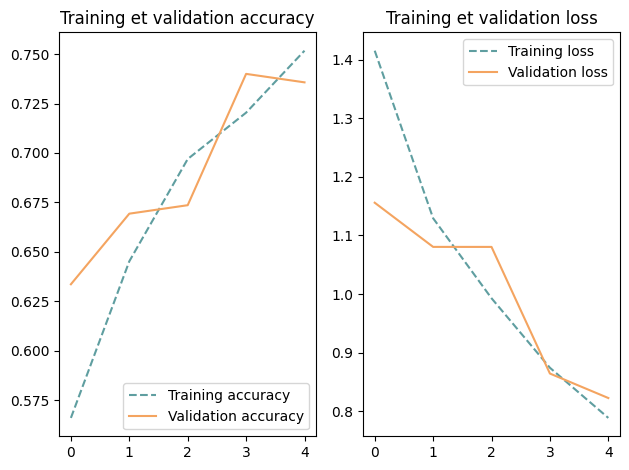

In [60]:
prediction(vgg_combined_fine, train_generator_augmented, validation_generator)
plot_training_analysis(vgg_combined_tuned_history2)

On obtient des résultats meilleurs en libérant les poids de VGG16. De plus, la loss et l'accuracy pour la validation et training sets suivent la même tendance: il n'y a pas d'overfitting notable.

On remarque que figer les poids de VGG16 pour la classification binaire a donné des résultats très bons comparés aux nôtres. Cela s'explique par le fait que pour le cas "chat vs chien", les dernières couches du VGG16 contiennent déjà suffisamment d’informations pour séparer ces deux catégories. Or ici, avec 35 classes, nous avons besoin de features subtiles spécifiques à chaque race, que le modèle pré-entraîné sur ImageNet n'arrive pas à capturer : le MLP final n’a pas assez d’informations pour distinguer des différences fines.

Débloquer certaines couches de VGG16 permet d’adapter les filtres convolutionnels aux différences fines entre races.

## Data transfer learning 2 

Essayons d'obtenir de meilleurs résultats en faisant un transfer learning avec un modèle plus adapté: DenseNet. J'utilise le modèle DenseNet121 (121 couches au total) qui devrait être suffisant, en théorie pas besoin d'utiliser DenseNet169 ou DenseNet201 qui ont un plus grands nombres de couches.

DenseNet121 utilise des connexions denses : chaque couche reçoit les caractéristiques de toutes les couches précédentes.
Cela permet de mieux capturer les détails fins, essentiels pour distinguer des classes très proches comme les races de chiens et chats.

In [20]:
dense_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

dense_model.summary()

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 156, 156,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 38, 38,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 38, 38,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 38, 38,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 38, 38,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 38, 38,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 38, 38,    │     12,288 │ conv2_block2_0_r

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [21]:
dense_combined_fine = Sequential()
dense_combined_fine.add(Input(shape=(img_width, img_height, 3)))
dense_combined_fine.add(dense_model)
dense_combined_fine.add(Flatten())
dense_combined_fine.add(Dense(256, activation='relu'))
dense_combined_fine.add(Dropout(0.5)) 
dense_combined_fine.add(Dense(35, activation='softmax')) 

dense_model.trainable = False # On fige les poids de DenseNet

dense_combined_fine.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 4, 4, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 35)             │         8,995 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,241,059 (42.88 MB)

 Trainable params: 4,203,555 (16.04 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [68]:
# Apprentissage 

epochs = 5

dense_combined_fine.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy']
)

t_learning_dense_combined_fine = time.time()
dense_combined_history = dense_combined_fine.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_dense_combined_fine = time.time() - t_learning_dense_combined_fine

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_dense_combined_fine))

Epoch 1/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 45s 130ms/step - accuracy: 0.1537 - loss: 3.8239 - val_accuracy: 0.6650 - val_loss: 1.2430
Epoch 2/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - accuracy: 0.3724 - loss: 2.2540 - val_accuracy: 0.7271 - val_loss: 0.9391
Epoch 3/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - accuracy: 0.4471 - loss: 1.9464 - val_accuracy: 0.7693 - val_loss: 0.7775
Epoch 4/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - accuracy: 0.4836 - loss: 1.7495 - val_accuracy: 0.7929 - val_loss: 0.7108
Epoch 5/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - accuracy: 0.5045 - loss: 1.6993 - val_accuracy: 0.7686 - val_loss: 0.7614
Learning time for 5 epochs : 150 seconds


260/260 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.7223 - loss: 0.9598
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7840 - loss: 0.7275
Train accuracy: 0.7055768966674805
Validation accuracy: 0.7685714364051819
Time Prediction: 26.79 seconds


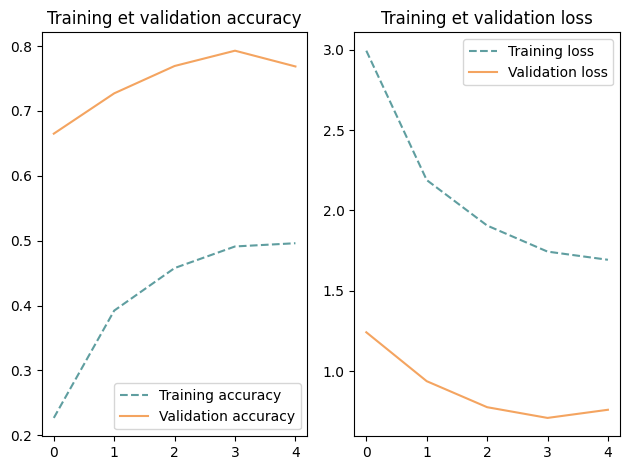

In [72]:
prediction(dense_combined_fine, train_generator_augmented, validation_generator)
plot_training_analysis(dense_combined_history)

### Test

Je teste sur le meilleur modèle: dense_combined_fine

In [93]:
test_prediction = dense_combined_fine.predict(test_generator)
score_test = dense_combined_fine.evaluate(test_generator)
print('Test accuracy:', score_test[1])

40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 290ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.7466 - loss: 0.8496
Test accuracy: 0.7569620013237


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


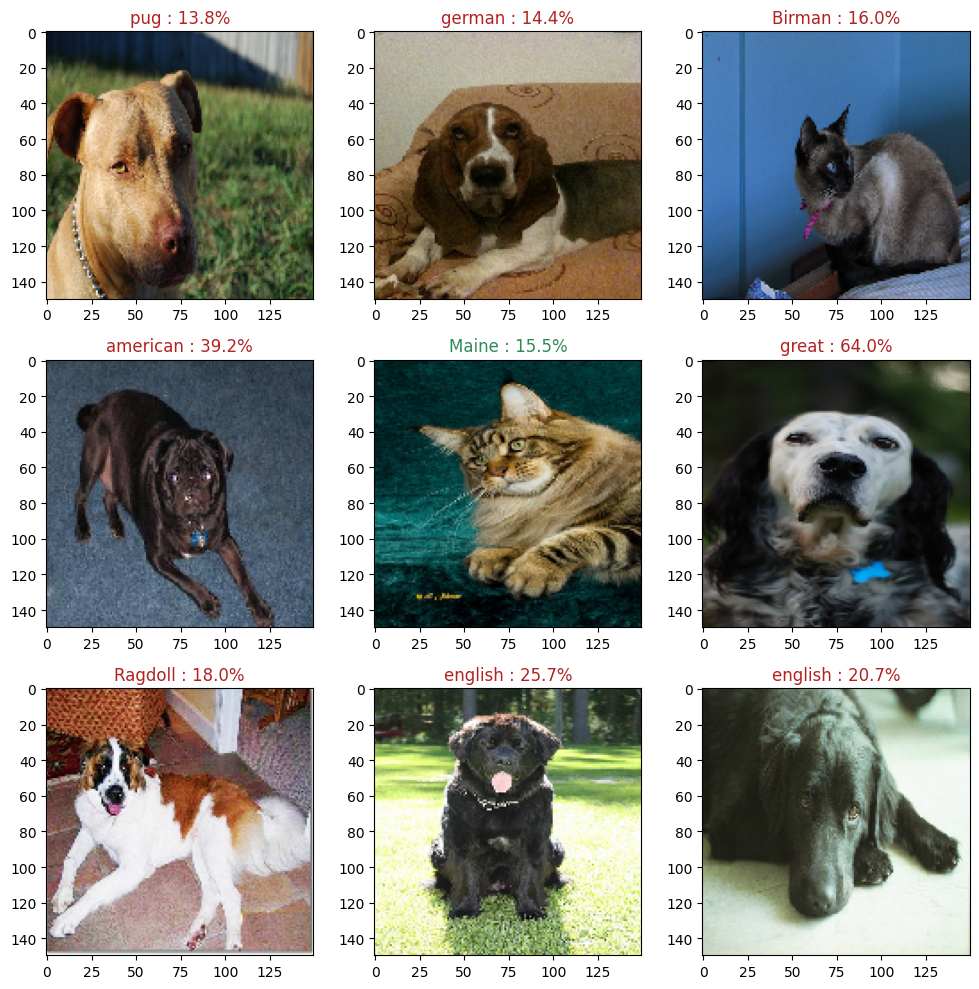

In [34]:
class_names = {v: k for k, v in test_generator.class_indices.items()}

x_batch, y_batch = next(test_generator)
# récupérer toutes les images et labels dans l'ordre exact
X_test, y_test = [], []
for i in range(len(test_generator)):
    x, y = test_generator[i] 
    # x_batch=Contient toutes les images du test set dans l’ordre exact du generator , x_batch.shape = (batch_size, img_width, img_height, 3)
    #y_test.shape = (nb_images, nb_classes), Contient tous les labels one-hot correspondants
    X_test.append(x)  
    y_test.append(y)
X_test = np.vstack(X_test)   #X_test[i] = image envoyée au modèle pour prédiction n°i
y_test = np.vstack(y_test)  #y_test[i] = label exact correspondant à X_test[i]
test_prediction = vgg_combined_fine.predict(X_test)

fig = plt.figure(figsize=(10,10))
indices = np.random.choice(len(X_test), 9, replace=False)

for i, idx in enumerate(indices):
    img = X_test[idx]
    pred = test_prediction[idx]
    #On utilise maintenant le label provenant directement du generator, pas du dataframe original
    pred_class_idx = np.argmax(pred)
    pred_class_prob = np.max(pred)
    true_class_idx = np.argmax(y_test[idx])
    
    ax = fig.add_subplot(3,3,i+1)
    ax.imshow(img)
    
    color = "seagreen" if pred_class_idx == true_class_idx else "firebrick"
    title = f"{class_names[pred_class_idx]} : {pred_class_prob*100:.1f}%"
    ax.set_title(title, color=color)

plt.tight_layout()
plt.show()


### Etude de la confusion

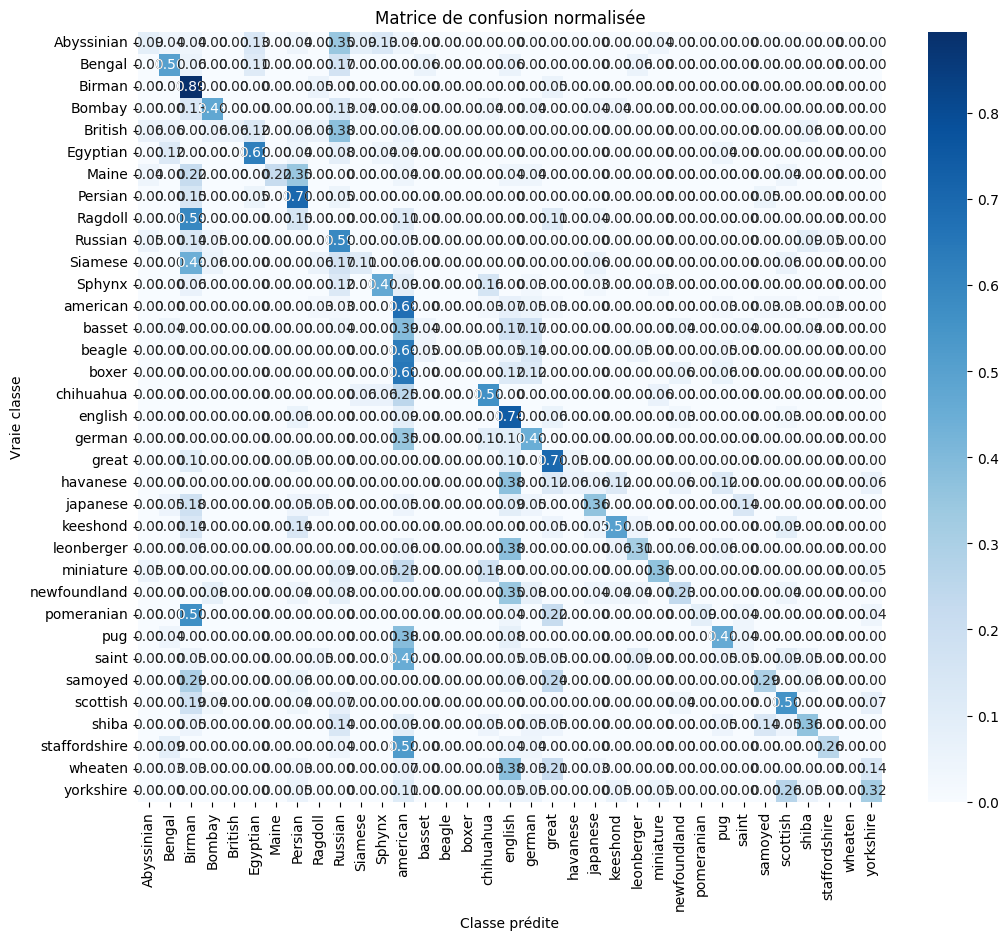

In [39]:
#del list

# classes réelles et prédictions
y_true = np.argmax(y_test, axis=1)   # ca prend l'indice de chaque classe du batch. y_test est code en one-hot donc ex pour 3 classes: [0,1,0] ici l'image est de classe 2 et pour chaque vecteur on prend le max donc le 1 donc ici ca renvoie 2 car l'indice du 1 est 2.
y_pred = np.argmax(test_prediction, axis=1)  # on prend la classe avec la probabilité maximale prédite par le modèle.

# matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# option : normaliser pour avoir des pourcentages
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# visualisation
plt.figure(figsize=(12,10))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=list(class_names.values()),
            yticklabels=list(class_names.values()))
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.title('Matrice de confusion normalisée')
plt.show()


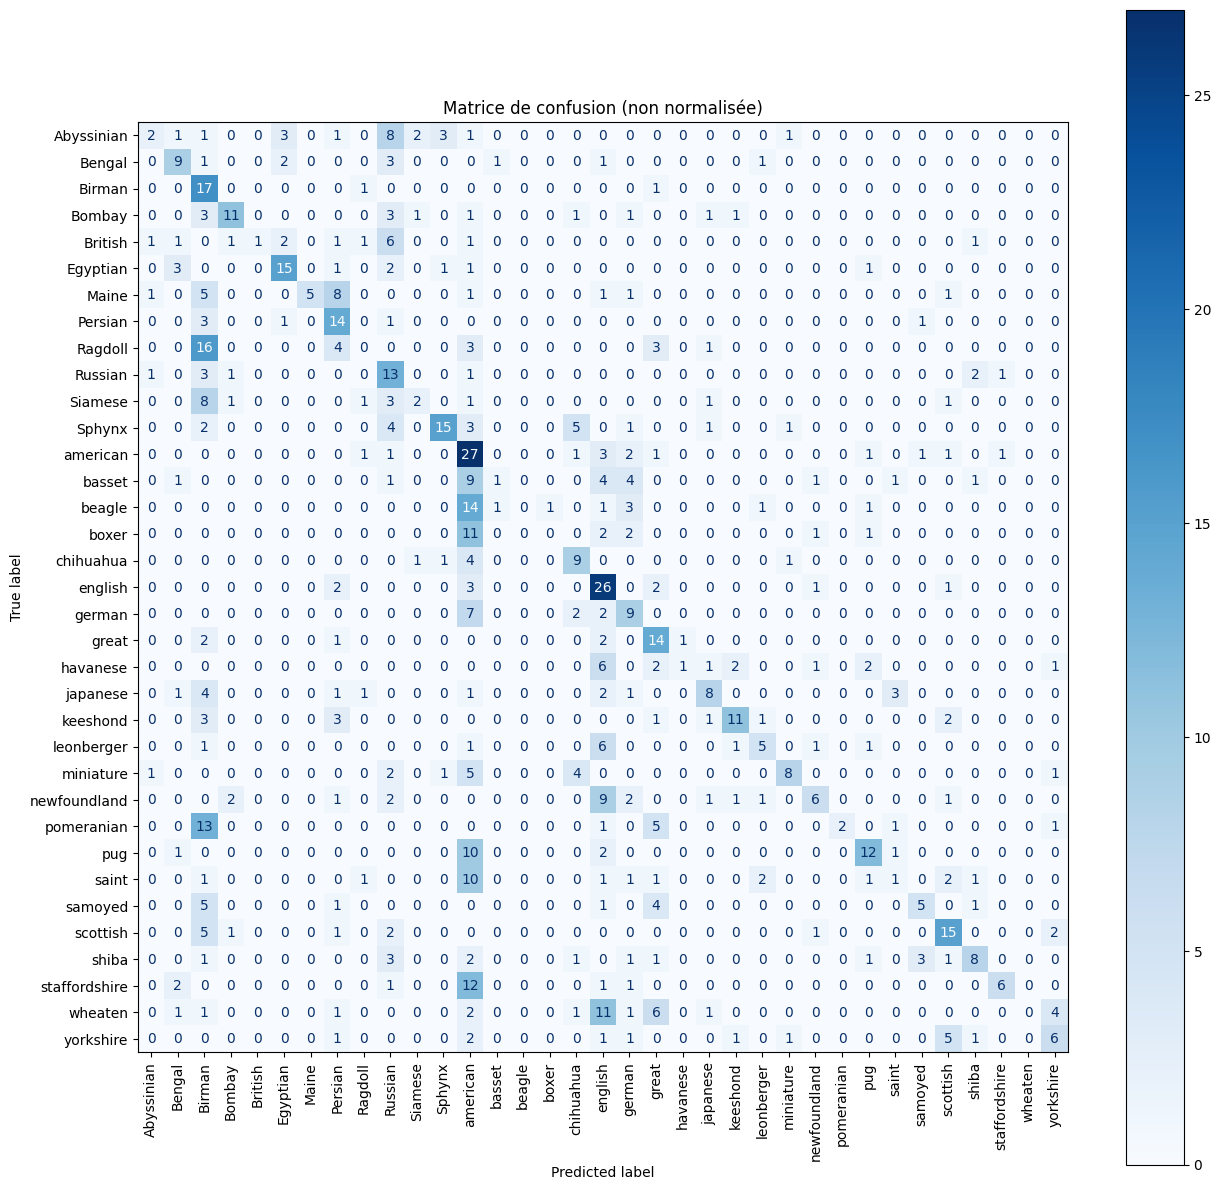

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay

# classes réelles et prédictions
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(test_prediction, axis=1)

# afficher la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_names.values()))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax, cmap='Blues', colorbar=True, values_format='d')
plt.xticks(rotation=90)
plt.title("Matrice de confusion (non normalisée)")
plt.show()


In [41]:
# Inverser pour obtenir {classe: index}
class_to_idx = {v: k for k, v in class_names.items()}

# Classes proches à analyser
classes_proches = ['Abyssinian', 'Bengal']

# Obtenir leurs indices
idx_proches = [class_to_idx[c] for c in classes_proches]
print(idx_proches)  # exemple : [0, 1]


[0, 1]


In [42]:
# y_true et y_pred pour tout le test set
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(test_prediction, axis=1)

# Filtrer uniquement les images de ces classes
mask = np.isin(y_true, idx_proches)
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]


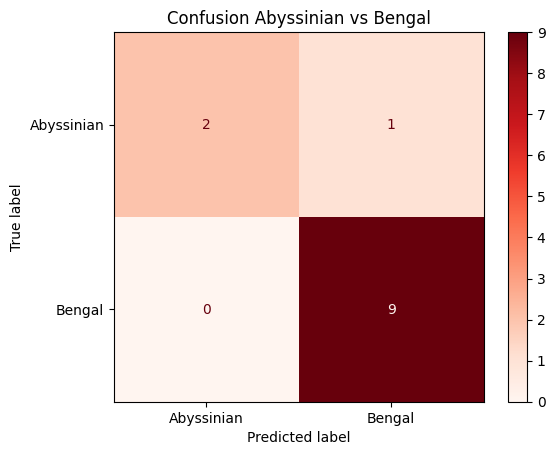

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_subset = confusion_matrix(y_true_filtered, y_pred_filtered, labels=idx_proches)

# Affichage
disp = ConfusionMatrixDisplay(cm_subset, display_labels=classes_proches)
disp.plot(cmap='Reds', values_format='d')
plt.title("Confusion Abyssinian vs Bengal")
plt.show()


**Faire pour d'autres races**

## Segmentation des animaux 

### Implémentation du réseau de type U-Net

Dans cette partie, nous allons nous intéresser à la segmentation des chiens et des chats grâce à un réseau U-Net: cela signifie que nous allons attribuer une "étiquette" à chaque pixel de notre image. On commence donc par préparer les images pour notre segmentation.

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_34 (Conv2D)          (None, 128, 128, 16)         448       ['input_5[0][0]']             
                                                                                                  
 conv2d_35 (Conv2D)          (None, 128, 128, 16)         2320      ['conv2d_34[0][0]']           
                                                                                                  
 max_pooling2d_12 (MaxPooli  (None, 64, 64, 16)           0         ['conv2d_35[0][0]']           
 ng2D)                                                                                      

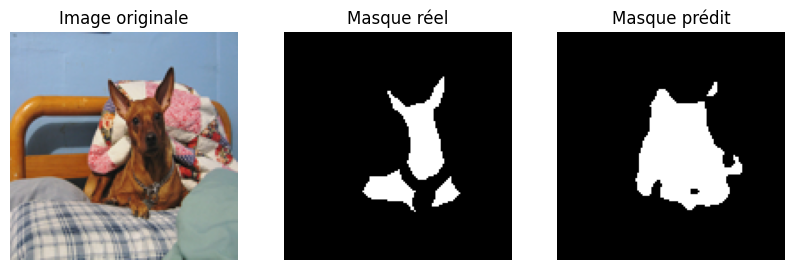

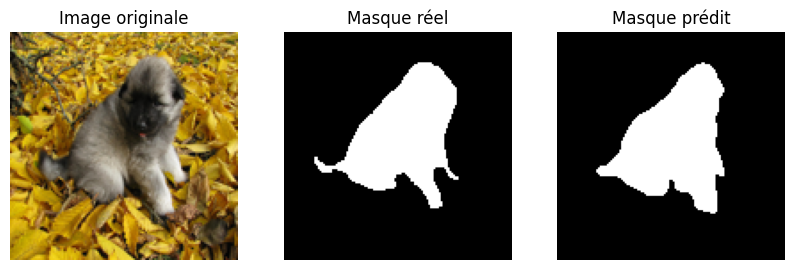

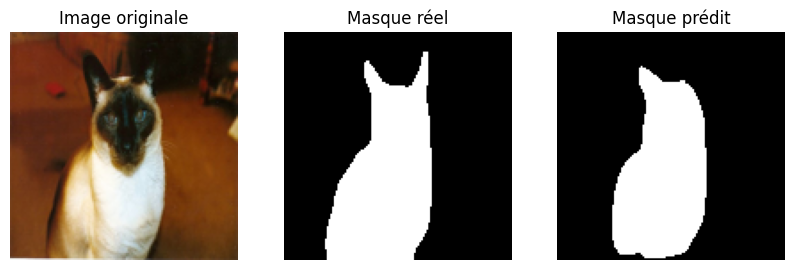

IoU: 0.4528665
Dice: 0.623411


In [25]:
# SEGMENTATION D'ANIMAUX AVEC U-NET

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rd
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# PARAMÈTRES GÉNÉRAUX

img_width = img_height = 128   # Test de taille uniforme mais pas convaincue par la taille, voir si amélioration possible
batch_size = 8

path_images = "./images/"
path_masks  = "./annotations/trimaps/"


# Split train / val / test
train_df = df.sample(frac=0.7, random_state=42)
temp_df  = df.drop(train_df.index)
validation_df = temp_df.sample(frac=0.5, random_state=42)
test_df = temp_df.drop(validation_df.index)

# GÉNÉRATEURS IMAGES + MASQUES

def image_generator(df, path_images, batch_size=8):
    while True:
        for i in range(0, len(df), batch_size):
            batch_df = df.iloc[i:i+batch_size]
            imgs = []
            for fname in batch_df['image']:
                img = np.array(
                    Image.open(path_images + fname)
                    .resize((img_width,img_height))
                    .convert("RGB")          # ⚠️ garantit 3 canaux
                )
                img = img / 255.0
                imgs.append(img)
            yield np.array(imgs, dtype=np.float32)


def mask_generator(df, path_masks, batch_size=8):
    while True:
        for i in range(0, len(df), batch_size):
            batch_df = df.iloc[i:i+batch_size]
            masks = []
            for fname in batch_df['image']:
                mask = np.array(
                    Image.open(path_masks + fname.replace('.jpg','.png'))
                    .resize((img_width,img_height))
                    .convert("L")            # ⚠️ niveaux de gris = 1 canal
                )
                # Binarisation : 1 = animal, 0 = fond
                mask_binary = np.where(mask == 1, 1, 0)[..., np.newaxis]
                masks.append(mask_binary)
            yield np.array(masks, dtype=np.float32)


# Fusionner les deux générateurs pour créer (image, masque)
def combined_generator(df, path_images, path_masks, batch_size=8):
    img_gen = image_generator(df, path_images, batch_size)
    mask_gen = mask_generator(df, path_masks, batch_size)
    while True:
        imgs = next(img_gen)
        masks = next(mask_gen)
        yield imgs, masks


# Train et Validation generators
train_generator = combined_generator(train_df, path_images, path_masks, batch_size)
validation_generator = combined_generator(validation_df, path_images, path_masks, batch_size)

# MODÈLE U-NET

def unet(input_size=(img_width, img_height, 3)):
    inputs = Input(input_size)

    # --- Encodeur ---
    c1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(64, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D()(c3)

    # --- Bottleneck ---
    c4 = Conv2D(128, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(128, 3, activation='relu', padding='same')(c4)

    # --- Decodeur ---
    u5 = UpSampling2D()(c4)
    u5 = Concatenate()([u5, c3])
    c5 = Conv2D(64, 3, activation='relu', padding='same')(u5)
    c5 = Conv2D(64, 3, activation='relu', padding='same')(c5)

    u6 = UpSampling2D()(c5)
    u6 = Concatenate()([u6, c2])
    c6 = Conv2D(32, 3, activation='relu', padding='same')(u6)
    c6 = Conv2D(32, 3, activation='relu', padding='same')(c6)

    u7 = UpSampling2D()(c6)
    u7 = Concatenate()([u7, c1])
    c7 = Conv2D(16, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(16, 3, activation='relu', padding='same')(c7)

    outputs = Conv2D(1, 1, activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model


model = unet()
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# ENTRAÎNEMENT

steps_per_epoch = len(train_df) // batch_size
validation_steps = len(validation_df) // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=10
)

# MÉTRIQUES DE SEGMENTATION

def iou(y_true, y_pred, smooth=1e-6):
    y_pred = tf.round(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_pred = tf.round(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2 * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)


# VISUALISATION DE RÉSULTATS

imgs, masks = next(train_generator)
preds = model.predict(imgs[:3])

for i in range(3):
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.imshow(imgs[i])
    plt.title("Image originale")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(masks[i,:,:,0], cmap="gray")
    plt.title("Masque réel")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(preds[i,:,:,0] > 0.5, cmap="gray")
    plt.title("Masque prédit")
    plt.axis("off")

    plt.show()

print("IoU:", iou(masks[:1], preds[:1]).numpy())
print("Dice:", dice_coef(masks[:1], preds[:1]).numpy())


## Analyse Comparative